In [ ]:
git_push_master()

Aktualisiere Repository mit 'git push'...


In [19]:
import tensorflow as tf
tf.version.VERSION

'2.6.0'

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow import keras
from matplotlib import colors
import os

In [5]:
# Oxford Pets Dataset laden
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True, data_dir="./data/")


In [6]:
# Examine the raw mask data
raw_train_dataset = dataset['train']
for datapoint in raw_train_dataset.take(1):
    raw_mask = datapoint['segmentation_mask']
    unique_values_raw = tf.unique(tf.reshape(raw_mask, [-1])).y.numpy()
    print("Unique values in the raw mask:", unique_values_raw)

Unique values in the raw mask: [2 3 1]


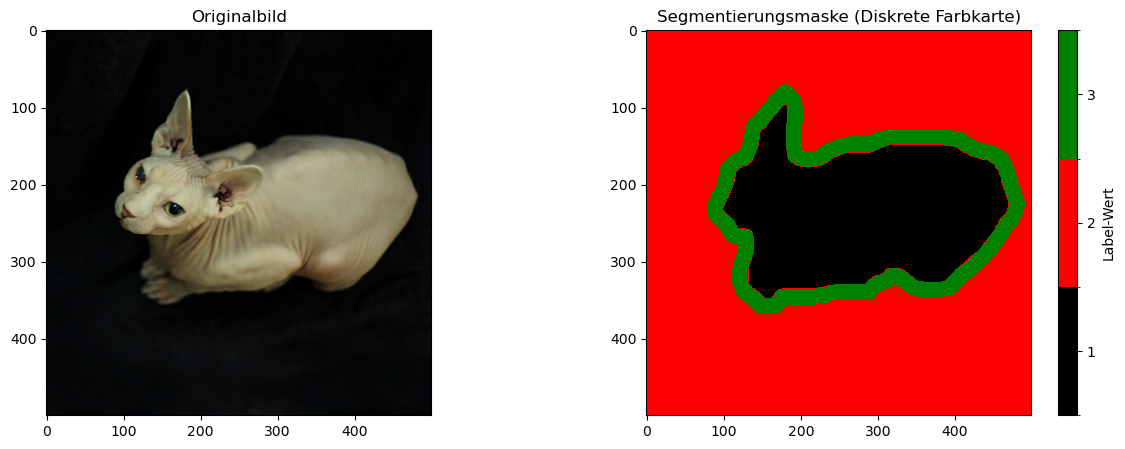

In [7]:
for datapoint in raw_train_dataset.take(1):
    image = datapoint['image']
    mask = datapoint['segmentation_mask']

    plt.figure(figsize=(15, 5))

    # Originalbild anzeigen
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Originalbild')

    # Diskrete Farbkarte erstellen, um Label-Werte spezifischen Farben zuzuordnen
    plt.subplot(1, 2, 2)

    # Farbkarte definieren: Farben für jedes Label
    cmap = colors.ListedColormap(['black', 'red', 'green'])
    
    # Grenzen der Farben definieren (angepasst an die Label-Werte)
    bounds = [0.5, 1.5, 2.5, 3.5]
    
    # Normalisierungsobjekt erstellen
    norm = colors.BoundaryNorm(bounds, cmap.N)

    # Maske mit der diskreten Farbkarte anzeigen
    plt.imshow(tf.squeeze(mask), cmap=cmap, norm=norm)
    plt.title('Segmentierungsmaske (Diskrete Farbkarte)')

    # Farbleiste mit Ticks an den Label-Positionen erstellen
    cbar = plt.colorbar(ticks=[1, 2, 3])
    cbar.ax.set_yticklabels(['1', '2', '3'])
    cbar.set_label('Label-Wert')

    plt.show()

Das Dataset enthält sowohl die Bilder der Haustiere als auch die Segmentierungsmasken. Wir müssen die Daten vorverarbeiten, um sie für unser Modell nutzbar zu machen.

### Datenvorverarbeitung
Nun müssen wir die Bilder und Masken in das richtige Format bringen (z. B. Normalisierung, Anpassung der Größe etc.).

In [8]:
# Bildgröße festlegen
IMG_SIZE = 256

def normalize(input_image, input_mask):
    """Normalize images to [0,1] and adjust masks to have values 0 and 1."""
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.int32)
    
    # Map label 3 (border/outline) to 1 (foreground)
    input_mask = tf.where(input_mask == 3, 1, input_mask)
    
    # Ensure the background remains 0
    input_mask = tf.where(input_mask != 1, 0, input_mask)
    
    return input_image, input_mask

def augment_image(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, 0.7, 1.3)
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    return image, mask


def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE), method='nearest')
    input_image, input_mask = augment_image(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE), antialias=True)
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE), method='nearest')
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask


# Trainings- und Testdaten vorbereiten
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 8
BUFFER_SIZE = 100

train_dataset = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = dataset['test'].map(load_image_test)

# Daten für das Training stapeln
train_dataset = train_dataset.shuffle(BUFFER_SIZE).cache().batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)


In [9]:
for image, mask in train_dataset.take(1):
    unique_values_after = tf.unique(tf.reshape(mask, [-1])).y.numpy()
    print("Unique values in the mask after normalization:", unique_values_after)


Unique values in the mask after normalization: [0 1]


In [10]:
for image, mask in train_dataset.take(1):
    print("Image shape:", image.shape)
    print("Image dtype:", image.dtype)
    print("Mask shape:", mask.shape)
    print("Mask dtype:", mask.dtype)


Image shape: (8, 256, 256, 3)
Image dtype: <dtype: 'float32'>
Mask shape: (8, 256, 256, 1)
Mask dtype: <dtype: 'int32'>


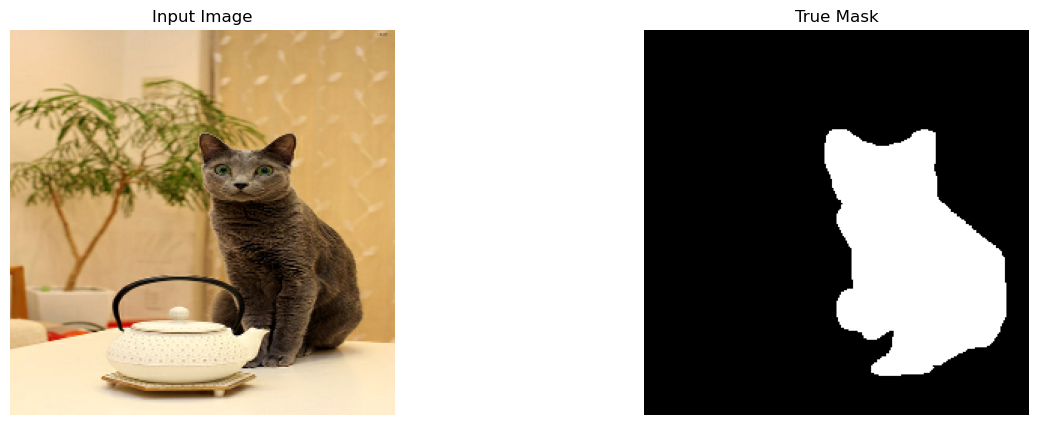

In [11]:
def display_sample(display_list):
    """Display image and mask side by side."""
    plt.figure(figsize=(15, 5))

    title = ['Input Image', 'True Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if i == 0:
            plt.imshow(display_list[i])
        else:
            plt.imshow(tf.squeeze(display_list[i]), cmap='gray')
        plt.axis('off')
    plt.show()

# Use the function
for image, mask in train_dataset.take(1):
    display_sample([image[0], mask[0]])


In [12]:
from tensorflow.keras import layers, models

def unet_model(input_size=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(0.3)(p1)  # Dropout nach dem ersten Pooling

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(0.3)(p2)  # Dropout nach dem zweiten Pooling

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    p3 = layers.Dropout(0.3)(p3)  # Höheres Dropout nach dem dritten Pooling

    # Bottleneck
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Dropout(0.3)(c4)  # Höheres Dropout im Bottleneck

    # Decoder
    u5 = layers.UpSampling2D((2, 2))(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Dropout(0.3)(c5)

    u6 = layers.UpSampling2D((2, 2))(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)
    c5 = layers.Dropout(0.3)(c5)

    u7 = layers.UpSampling2D((2, 2))(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model

# Modell initialisieren
model = unet_model()

def iou_metric(y_true, y_pred):
    """Calculate Intersection over Union."""
    # Threshold predictions to binary values
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    # Compute intersection and union
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true + y_pred - y_true * y_pred)
    # Compute IoU
    iou = intersection / (union + 1e-7)
    return iou


model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy', iou_metric])


In [10]:
EPOCHS = 15
steps_per_epoch = TRAIN_LENGTH // BATCH_SIZE

# Modelltraining starten
history = model.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=test_dataset)

model.save('./models/u-net-256.keras')


Epoch 1/15
460/460 [==============================] - 310s 619ms/step - loss: 0.5213 - accuracy: 0.7370 - iou_metric: 0.5097 - val_loss: 0.8625 - val_accuracy: 0.6756 - val_iou_metric: 0.3135
Epoch 2/15
460/460 [==============================] - 280s 609ms/step - loss: 0.3923 - accuracy: 0.8272 - iou_metric: 0.6543 - val_loss: 0.4317 - val_accuracy: 0.8059 - val_iou_metric: 0.6451
Epoch 3/15
460/460 [==============================] - 280s 608ms/step - loss: 0.3477 - accuracy: 0.8505 - iou_metric: 0.6938 - val_loss: 0.3950 - val_accuracy: 0.8344 - val_iou_metric: 0.6916
Epoch 4/15
460/460 [==============================] - 280s 609ms/step - loss: 0.3204 - accuracy: 0.8638 - iou_metric: 0.7176 - val_loss: 0.3261 - val_accuracy: 0.8659 - val_iou_metric: 0.7271
Epoch 5/15
460/460 [==============================] - 280s 609ms/step - loss: 0.3036 - accuracy: 0.8716 - iou_metric: 0.7315 - val_loss: 0.2924 - val_accuracy: 0.8755 - val_iou_metric: 0.7293
Epoch 6/15
460/460 [====================

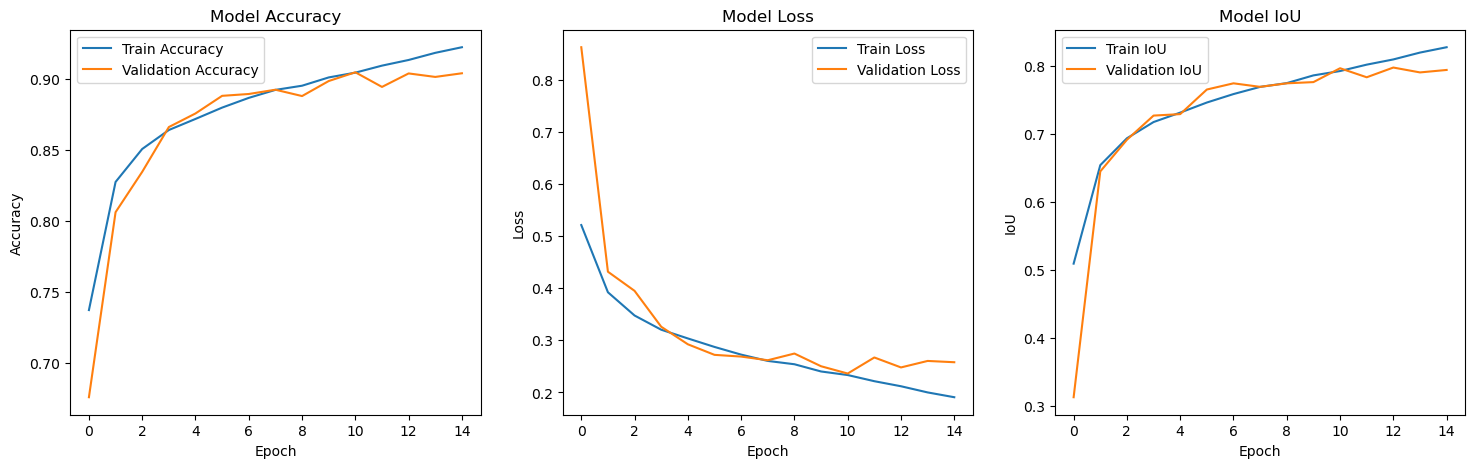

In [11]:
# Plot training & validation IoU values
plt.figure(figsize=(18, 5))

# Plot accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot IoU
plt.subplot(1, 3, 3)
plt.plot(history.history['iou_metric'], label='Train IoU')
plt.plot(history.history['val_iou_metric'], label='Validation IoU')
plt.title('Model IoU')
plt.ylabel('IoU')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()


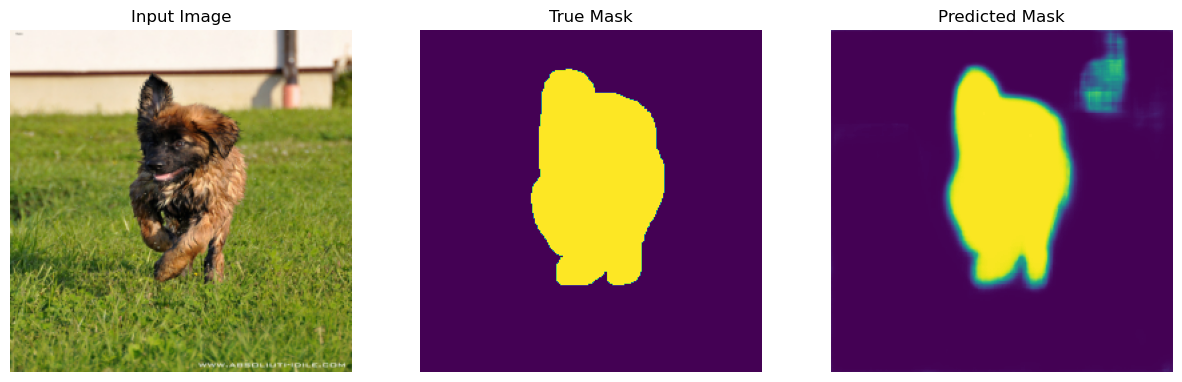

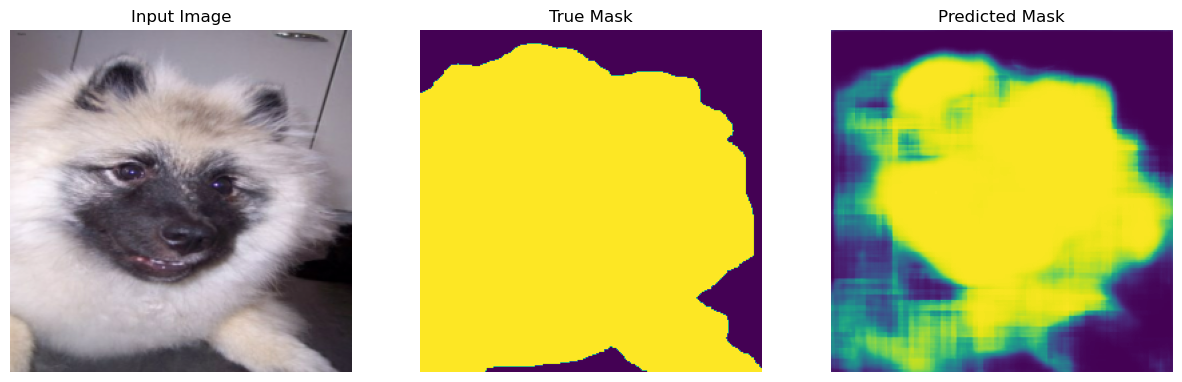

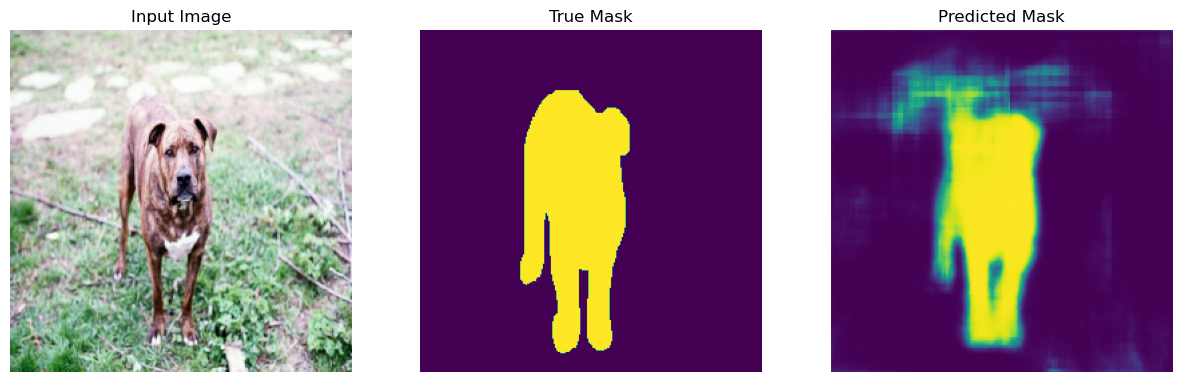

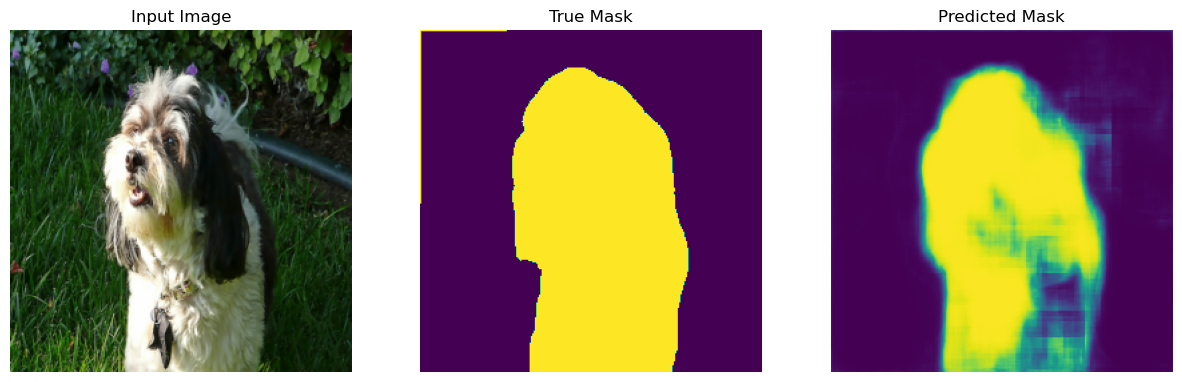

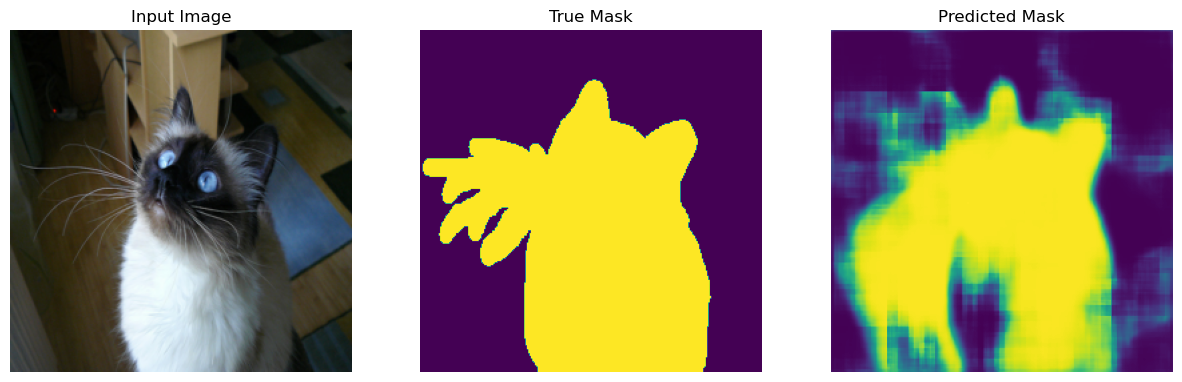

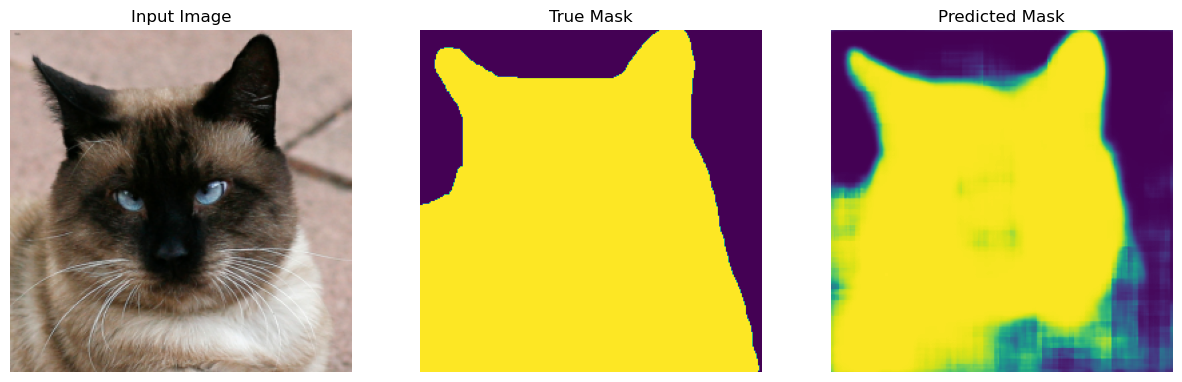

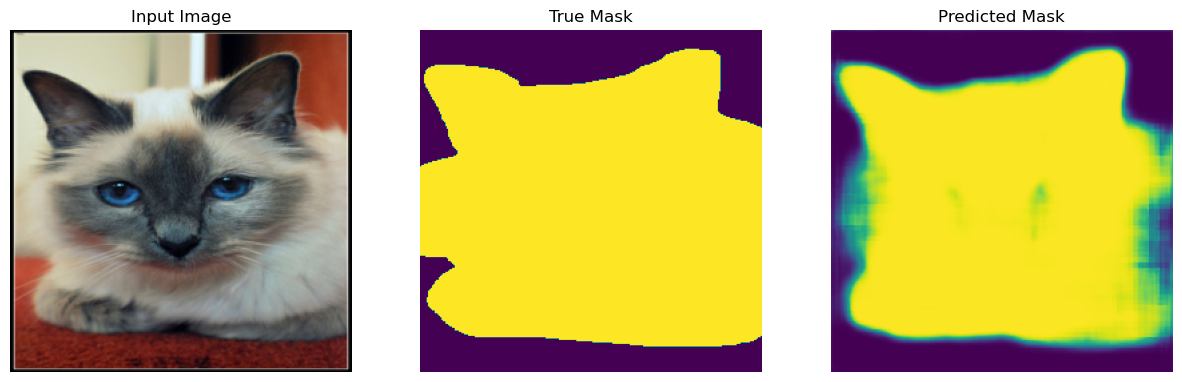

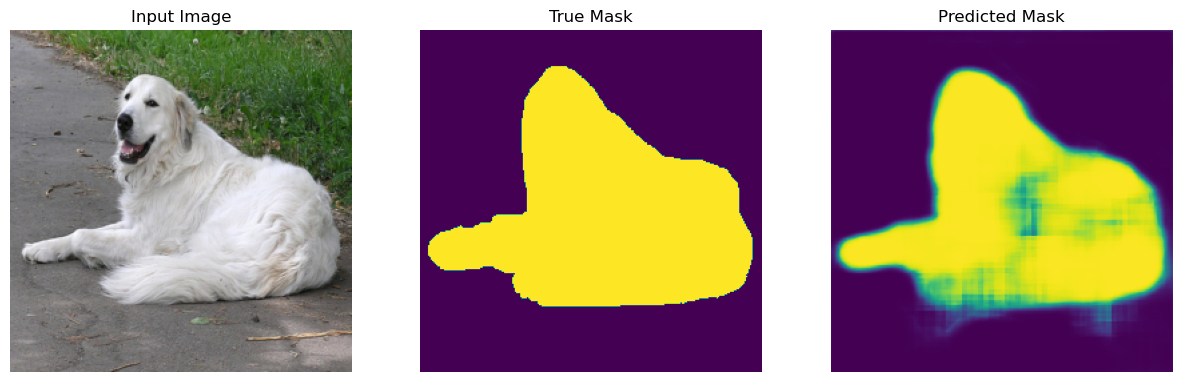

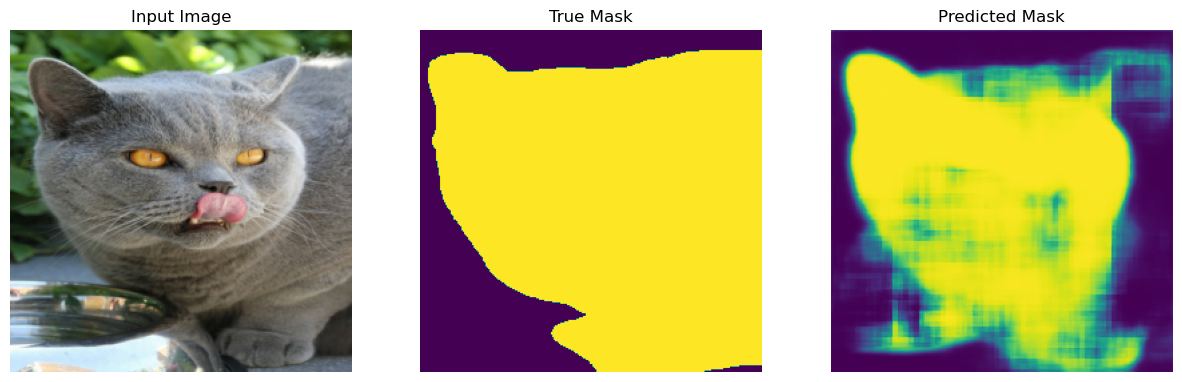

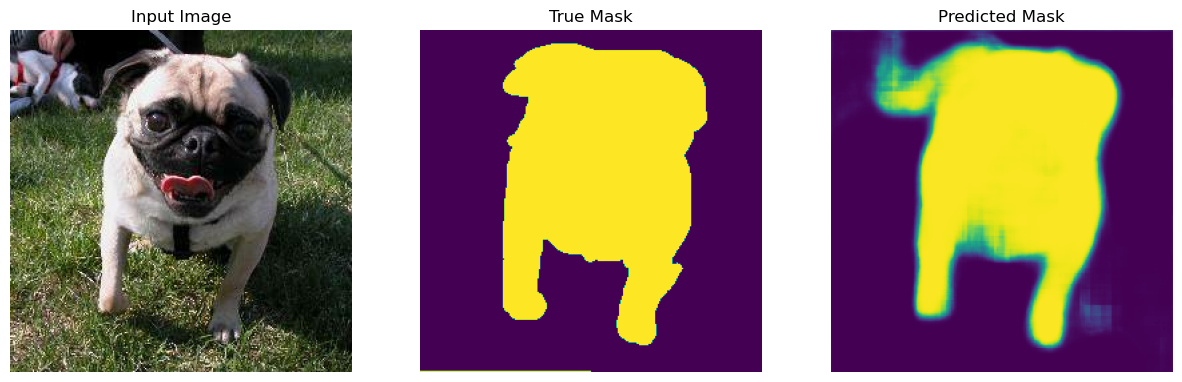

In [29]:
import tensorflow.keras

def iou_metric(y_true, y_pred):
    """Calculate Intersection over Union."""
    # Threshold predictions to binary values
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    # Compute intersection and union
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true + y_pred - y_true * y_pred)
    # Compute IoU
    iou = intersection / (union + 1e-7)
    return iou
    
# Modell laden
model = tf.keras.models.load_model('./models/u-net-256.keras', custom_objects={'iou_metric': iou_metric})

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

# Vorhersage für ein Testbild anzeigen
for image, mask in test_dataset.take(10):
    pred_mask = model.predict(image)
    display([image[0], mask[0], pred_mask[0]])


In [31]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import os

def preprocess_image(img_path, target_size=(256, 256)):
    """
    Lädt ein Bild von einem Pfad, skaliert es auf die Zielgröße, normalisiert die Pixelwerte
    und fügt eine Batch-Dimension hinzu.
    
    Args:
        img_path (str): Pfad zum Bild.
        target_size (tuple): Zielgröße für das Bild (Höhe, Breite).
        
    Returns:
        np.array: Vorgearbeitetes Bild mit Batch-Dimension.
    """
    # Bild laden
    img = image.load_img(img_path, target_size=target_size)
    # Bild in Array umwandeln
    img_array = image.img_to_array(img)
    # Normalisierung (so wie beim Training)
    img_array /= 255.0
    # Hinzufügen einer Batch-Dimension
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


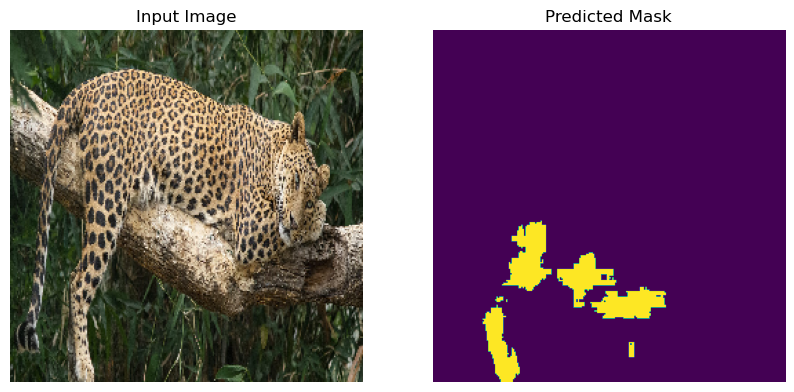

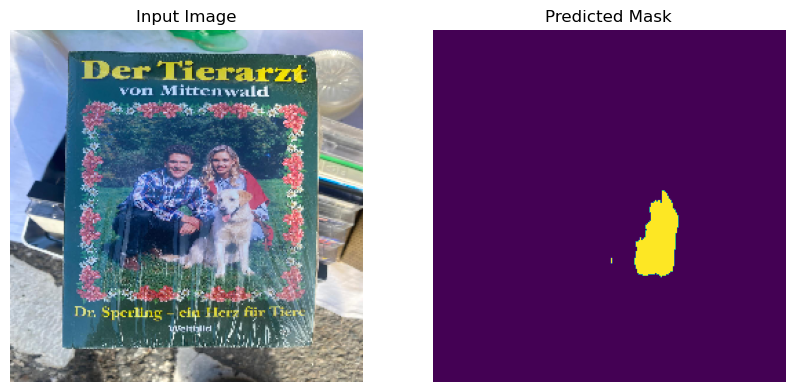

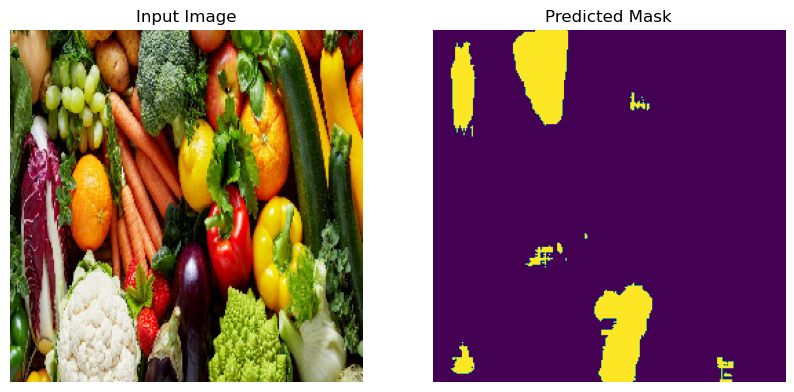

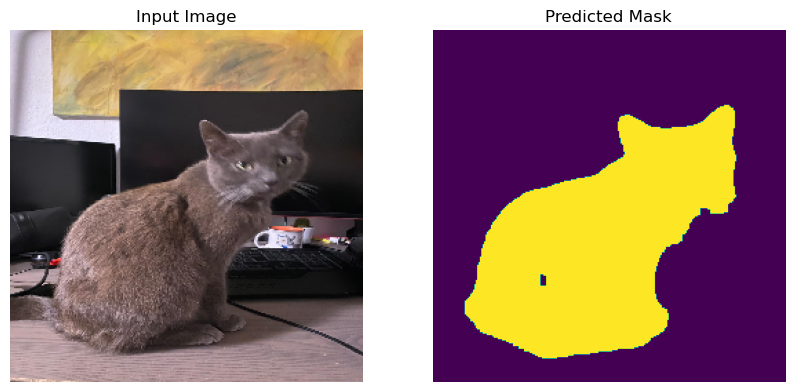

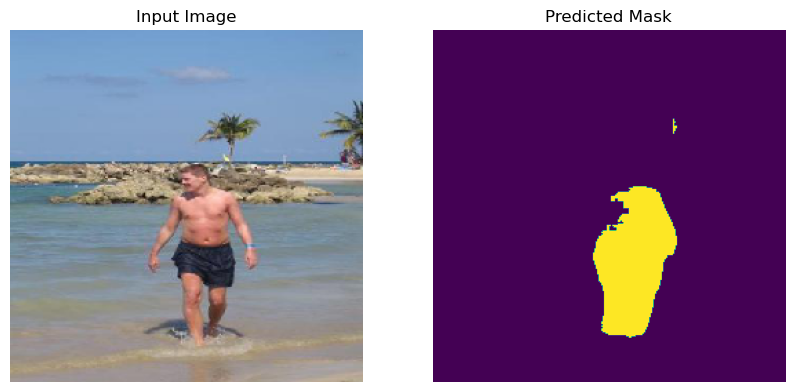

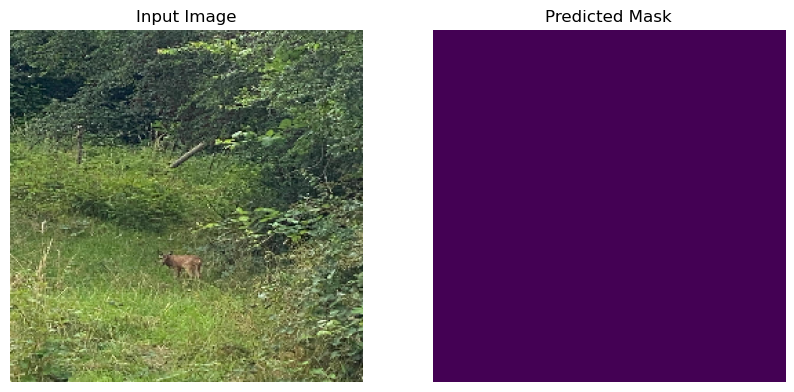

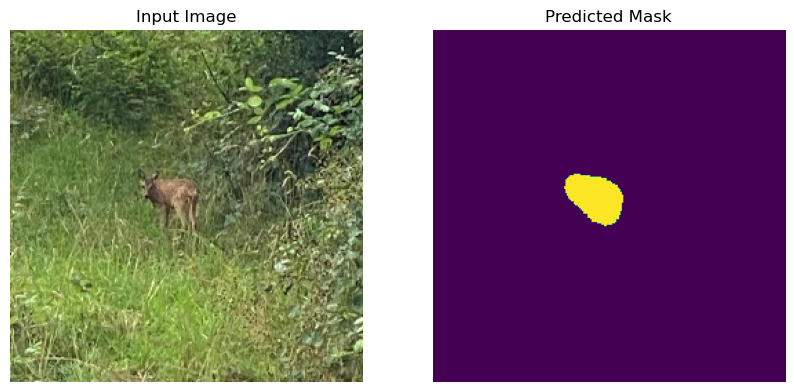

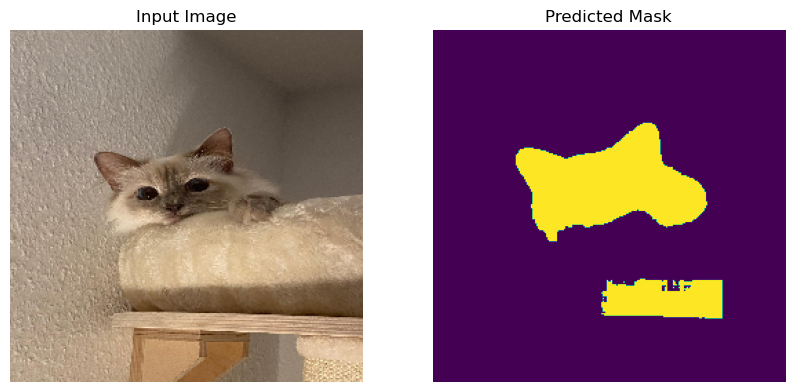

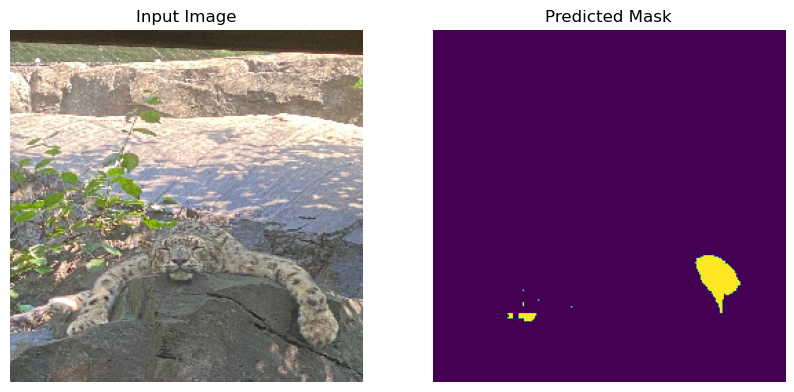

In [33]:
# Ordner mit den eigenen Beispielen
ordner_pfad = './own_examples'

# Bilder im Ordner durchlaufen
for bild_datei in os.listdir(ordner_pfad):
    if bild_datei.endswith(('.png', '.jpg', '.jpeg', '.jfif')):  # Unterstützte Bildformate
        bild_pfad = os.path.join(ordner_pfad, bild_datei)

        # Bild vorverarbeiten
        vorverarbeitetes_bild = preprocess_image(bild_pfad)

        # Vorhersage durchführen (Modell annehmen, dass es bereits geladen ist)
        pred_mask = model.predict(vorverarbeitetes_bild)

        threshold = 0.70  
        pred_mask = (model.predict(vorverarbeitetes_bild) > threshold).astype(np.uint8)


        # Bilder anzeigen
        plt.figure(figsize=(10, 10))

        plt.subplot(1, 2, 1)
        plt.title("Input Image")
        plt.imshow(tf.keras.preprocessing.image.array_to_img(vorverarbeitetes_bild[0]))
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Predicted Mask")
        plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[0]))
        plt.axis('off')

        plt.show()